# Purpose of notebook
This notebook is explore the roles classification problem. The goal of this analysis is to identify what attributes are good at predicting the role, independent of character.

Roles questions:
1. If I group the data by characters into the 4 classes (duelist, initiator, controller, sentinel) can I classify the data based on those classes (those are the labels)
    1. Ideally I would be able to see which features are driving the classification per class and in total?
2. Is it possible to cluster the data?
    1. I think features could be less important in the sense that we could observe the grouping and see what roles make sense from the data?
    2. We make this the new classes and similarly try to classify

## Additional background / hypothesis
* Commonly in gaming there is the concept of "role" similar to positions in sports
* In Valorant, characters are grouped into 4 main roles and their "kit" is designed to fill that role
    - Controller
    - Initiator
    - Duelist
    - Sentinels
* Some characters are a bit fluid (can play multiple roles) but generally the character is a good proxy for role
* However the player can ignore the kit/character and still play a different "role" even if their character isnt designed for it
* There are sub-roles
* There is a general idea that in order to have the best chance of winning, you should have a 2 sentinels, 1 initiator, 1 duelist, 1 controller

### Hypothesis/questions
* Is it possible to group players by their gameplay (how different is their gameplay)?
    * Idea: we know the different people's ids, if we cluster the data and see how many clusters it forms (DBSCAN?) will it be similar or different to the ammount of people we have?
* Is it possible to determine how well a player is playing the role assigned by the character but independent of character?
    * Idea: we gather data from the "best" professionals in each character role, and treat this as the ground truth for that role
        * then we can measure how close a player is playing that role
        * could also attempt to classify based on the ground truth
* It it possible to prove/disprove the team-comp sentiment?
    * Idea: once we have a good idea of what leads to wins/losses, we can add in different character comps and see how that influeces match outcomes? basically try and see if the ratio of characters/roles actually matters
* Is it possible to show that certain characters/roles are more important/relevant depending on the STATE of the match (what has happened??)
    * Idea: classify/catagorize matches into opening, mid, end game based on events (like chess) to determine strategy, and then see which roles are most effective at progressing the match to the next event.

Defensive:
- sentinels: support and/or in game leader
    - healing 
    - moving around the map (information)
    -Cypher; Killjoy; Chamber; and Sage
    - slowing down opponents on bomb site

- initiators: recon and crowd control
    - Sova, Skye, Fade and Gekko rely on their abilities to perform reconnaissance
    - Breach and KAY/O specialise in disrupting enemies in their path through the use of their crowd control abilities

Offensive
- controllers: secondary entry frag and lurker 
    - Ability smoke screen
    - Use abilities before spike plant
    - Astra; Brimstone; Omen; Harbor and Viper.
    - Second on the scene
    - Omen is a flank

- duelist: entry drag
    - Damage dealers
    - Jett; Phoenix; Raze; Reyna; Yoru and Neon.
    - First person on an area on a map
    - Good aim

    

https://www.pinnacle.com/en/esports-hub/betting-articles/valorant/roles-in-valorant/gx9jvkedjdeh2ygl#:~:text=the%20team%20wins.-,What%20are%20the%20different%20roles%20in%20VALORANT%3F,%2C%20Recon%2C%20and%20Crowd%20Control. 



In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt

## Loading the data

In [2]:
import pandas as pd

# Read the CSV files into separate DataFrames
df1 = pd.read_csv('dev_data_norm_round_spikesplit.csv')
df2 = pd.read_csv('pro1_data_norm_round_spikesplit.csv')
df3 = pd.read_csv('pro2_data_norm_round_spikesplit.csv')

# Concatenate the DataFrames vertically
df = pd.concat([df1, df2, df3], ignore_index=True)

df

,user_id,map,player,ally4_character,self_character,ally1_character,ally2_character,ally3_character,opponent5_character,opponent6_character,...,self_pre_spike_total_loadout_value_loss,self_post_spike_total_loadout_value_loss,self_pre_spike_total_ability_usage_1,self_post_spike_total_ability_usage_1,self_pre_spike_total_ability_usage_2,self_post_spike_total_ability_usage_2,self_pre_spike_total_ability_usage_3,self_post_spike_total_ability_usage_3,self_pre_spike_total_ability_usage_4,self_post_spike_total_ability_usage_4
0,1006,Pearl,1,phoenix,jett,gekko,cypher,astra,harbor,astra,...,1834.0,0.0,0,0,1,0,1,0,0,0
1,1006,Pearl,1,phoenix,jett,gekko,cypher,astra,harbor,astra,...,7700.0,0.0,1,0,0,0,1,0,1,0
2,1006,Pearl,1,phoenix,jett,gekko,cypher,astra,harbor,astra,...,8350.0,3600.0,1,0,1,0,1,0,0,0
3,1006,Pearl,1,phoenix,jett,gekko,cypher,astra,harbor,astra,...,2136.0,0.0,1,0,0,0,1,0,0,0
4,1006,Pearl,1,phoenix,jett,gekko,cypher,astra,harbor,astra,...,800.0,0.0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28954,3795,unknown,0,breach,jett,skye,sova,reyna,jett,gekko,...,5800.0,0.0,1,0,0,0,1,0,0,0
28955,3795,unknown,0,breach,jett,skye,sova,reyna,jett,gekko,...,2800.0,0.0,1,0,0,0,1,0,0,0
28956,3795,unknown,0,breach,jett,skye,sova,reyna,jett,gekko,...,2000.0,1200.0,0,0,0,0,0,0,0,0
28957,3795,unknown,0,breach,jett,skye,sova,reyna,jett,gekko,...,2200.0,3000.0,1,0,0,0,0,0,1,0


In [3]:
# Find rows with NaN values
nan_rows = df[df.isnull().any(axis=1)]

# Print the rows with NaN values
nan_rows

,user_id,map,player,ally4_character,self_character,ally1_character,ally2_character,ally3_character,opponent5_character,opponent6_character,...,self_pre_spike_total_loadout_value_loss,self_post_spike_total_loadout_value_loss,self_pre_spike_total_ability_usage_1,self_post_spike_total_ability_usage_1,self_pre_spike_total_ability_usage_2,self_post_spike_total_ability_usage_2,self_pre_spike_total_ability_usage_3,self_post_spike_total_ability_usage_3,self_pre_spike_total_ability_usage_4,self_post_spike_total_ability_usage_4


In [4]:
df.columns[:100]

Index(['user_id', 'map', 'player', 'ally4_character', 'self_character',
       'ally1_character', 'ally2_character', 'ally3_character',
       'opponent5_character', 'opponent6_character', 'opponent7_character',
       'opponent8_character', 'opponent9_character', 'spike_planted',
       'spike_time', 'round_number', 'round_info_ally_side',
       'round_info_round_end', 'round_info_round_won',
       'round_info_round_start', 'ally4_pre_spike_elims',
       'ally4_post_spike_elims', 'ally4_pre_spike_deaths',
       'ally4_post_spike_deaths', 'ally4_pre_spike_assists',
       'ally4_post_spike_assists', 'ally4_pre_spike_headshots',
       'ally4_post_spike_headshots', 'ally4_pre_spike_wallbangs',
       'ally4_post_spike_wallbangs', 'ally4_pre_spike_first_bloods',
       'ally4_post_spike_first_bloods', 'self_pre_spike_elims',
       'self_post_spike_elims', 'self_pre_spike_deaths',
       'self_post_spike_deaths', 'self_pre_spike_assists',
       'self_post_spike_assists', 'self_pre_s

In [5]:
df.columns[100:200]

Index(['opponent1_pre_spike_wallbangs', 'opponent1_post_spike_wallbangs',
       'opponent1_pre_spike_first_bloods', 'opponent1_post_spike_first_bloods',
       'opponent2_pre_spike_elims', 'opponent2_post_spike_elims',
       'opponent2_pre_spike_deaths', 'opponent2_post_spike_deaths',
       'opponent2_pre_spike_assists', 'opponent2_post_spike_assists',
       'opponent2_pre_spike_headshots', 'opponent2_post_spike_headshots',
       'opponent2_pre_spike_wallbangs', 'opponent2_post_spike_wallbangs',
       'opponent2_pre_spike_first_bloods', 'opponent2_post_spike_first_bloods',
       'opponent3_pre_spike_elims', 'opponent3_post_spike_elims',
       'opponent3_pre_spike_deaths', 'opponent3_post_spike_deaths',
       'opponent3_pre_spike_assists', 'opponent3_post_spike_assists',
       'opponent3_pre_spike_headshots', 'opponent3_post_spike_headshots',
       'opponent3_pre_spike_wallbangs', 'opponent3_post_spike_wallbangs',
       'opponent3_pre_spike_first_bloods', 'opponent3_post_spi

In [6]:
df.columns[200:]

Index(['ally1_pre_spike_ultimate_usage', 'ally1_post_spike_ultimate_usage',
       'ally2_ultimate_usage', 'ally2_pre_spike_ultimate_usage',
       'ally2_post_spike_ultimate_usage', 'ally3_ultimate_usage',
       'ally3_pre_spike_ultimate_usage', 'ally3_post_spike_ultimate_usage',
       'opponent0_ultimate_usage', 'opponent0_pre_spike_ultimate_usage',
       'opponent0_post_spike_ultimate_usage', 'opponent1_ultimate_usage',
       'opponent1_pre_spike_ultimate_usage',
       'opponent1_post_spike_ultimate_usage', 'opponent2_ultimate_usage',
       'opponent2_pre_spike_ultimate_usage',
       'opponent2_post_spike_ultimate_usage', 'opponent3_ultimate_usage',
       'opponent3_pre_spike_ultimate_usage',
       'opponent3_post_spike_ultimate_usage', 'opponent4_ultimate_usage',
       'opponent4_pre_spike_ultimate_usage',
       'opponent4_post_spike_ultimate_usage', 'self_pre_spike_map_covered',
       'self_pre_spike_movement_metric', 'self_post_spike_map_covered',
       'self_post_sp

In [7]:
df.iloc[0][:50]

user_id                              1006
map                                 Pearl
player                                  1
ally4_character                   phoenix
self_character                       jett
ally1_character                     gekko
ally2_character                    cypher
ally3_character                     astra
opponent5_character                harbor
opponent6_character                 astra
opponent7_character                  jett
opponent8_character               phoenix
opponent9_character               killjoy
spike_planted                       False
spike_time                              0
round_number                            7
round_info_ally_side             attacker
round_info_round_end               124802
round_info_round_won                 True
round_info_round_start               4723
ally4_pre_spike_elims                   0
ally4_post_spike_elims                  0
ally4_pre_spike_deaths                  0
ally4_post_spike_deaths           

In [8]:
df.iloc[0][50:]

ally1_pre_spike_headshots                0
ally1_post_spike_headshots               0
ally1_pre_spike_wallbangs                0
ally1_post_spike_wallbangs               0
ally1_pre_spike_first_bloods             0
                                        ..
self_post_spike_total_ability_usage_2    0
self_pre_spike_total_ability_usage_3     1
self_post_spike_total_ability_usage_3    0
self_pre_spike_total_ability_usage_4     0
self_post_spike_total_ability_usage_4    0
Name: 0, Length: 206, dtype: object

## Data pre-processing
- Dropped 2 cols I don't need
- Checked to see if there are NaNs and 'unknowns'
- Because map wasn't really seeming to be a major influence on W/L ratio I am leaving the unknowns in
- However attacker vs defender could probably be an issue...


- Translated the boolean cols to 0 and 1
- One-hot encode categorical variables
- StandardScaler for numeric ...

In [9]:
df = df.drop(['player','round_number'], axis=1)

### encoding boolean features


NameError: name 'plt' is not defined

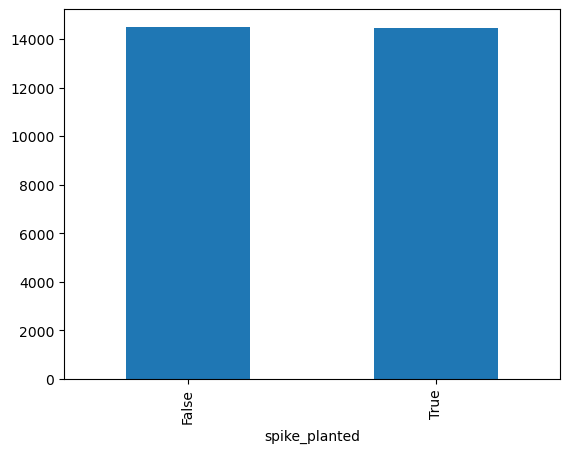

In [10]:
grouped_df = df.groupby('spike_planted').size()

grouped_df.plot(kind='bar')

plt.xlabel('Spike Planted')
plt.ylabel('Count')
plt.title('Grouped Data by Spike Planted')

plt.show()

In [ ]:
grouped_df = df.groupby('round_info_ally_side').size()

grouped_df.plot(kind='bar')

plt.xlabel('ally status')
plt.ylabel('Count')
plt.title('Grouped Data by ally status')

plt.show()

In [ ]:
grouped_df = df.groupby('map').size()

grouped_df.plot(kind='bar')

plt.xlabel('Map')
plt.ylabel('Count')
plt.title('Grouped Data by Map')

plt.show()

In [ ]:
grouped_df = df.groupby('round_info_round_won').size()

grouped_df.plot(kind='bar')

plt.xlabel('round_info_round_won')
plt.ylabel('Count')
plt.title('Grouped Data by round_info_round_won')

plt.show()

In [11]:
mapping = {True: 1, False: 0}
df.loc[:, 'spike_planted'] = df['spike_planted'].map(mapping)
df

,user_id,map,ally4_character,self_character,ally1_character,ally2_character,ally3_character,opponent5_character,opponent6_character,opponent7_character,...,self_pre_spike_total_loadout_value_loss,self_post_spike_total_loadout_value_loss,self_pre_spike_total_ability_usage_1,self_post_spike_total_ability_usage_1,self_pre_spike_total_ability_usage_2,self_post_spike_total_ability_usage_2,self_pre_spike_total_ability_usage_3,self_post_spike_total_ability_usage_3,self_pre_spike_total_ability_usage_4,self_post_spike_total_ability_usage_4
0,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,1834.0,0.0,0,0,1,0,1,0,0,0
1,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,7700.0,0.0,1,0,0,0,1,0,1,0
2,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,8350.0,3600.0,1,0,1,0,1,0,0,0
3,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,2136.0,0.0,1,0,0,0,1,0,0,0
4,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,800.0,0.0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28954,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,5800.0,0.0,1,0,0,0,1,0,0,0
28955,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,2800.0,0.0,1,0,0,0,1,0,0,0
28956,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,2000.0,1200.0,0,0,0,0,0,0,0,0
28957,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,2200.0,3000.0,1,0,0,0,0,0,1,0


In [12]:
mapping = {True: 1, False: 0}
df.loc[:, 'round_info_round_won'] = df['round_info_round_won'].map(mapping)
df

,user_id,map,ally4_character,self_character,ally1_character,ally2_character,ally3_character,opponent5_character,opponent6_character,opponent7_character,...,self_pre_spike_total_loadout_value_loss,self_post_spike_total_loadout_value_loss,self_pre_spike_total_ability_usage_1,self_post_spike_total_ability_usage_1,self_pre_spike_total_ability_usage_2,self_post_spike_total_ability_usage_2,self_pre_spike_total_ability_usage_3,self_post_spike_total_ability_usage_3,self_pre_spike_total_ability_usage_4,self_post_spike_total_ability_usage_4
0,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,1834.0,0.0,0,0,1,0,1,0,0,0
1,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,7700.0,0.0,1,0,0,0,1,0,1,0
2,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,8350.0,3600.0,1,0,1,0,1,0,0,0
3,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,2136.0,0.0,1,0,0,0,1,0,0,0
4,1006,Pearl,phoenix,jett,gekko,cypher,astra,harbor,astra,jett,...,800.0,0.0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28954,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,5800.0,0.0,1,0,0,0,1,0,0,0
28955,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,2800.0,0.0,1,0,0,0,1,0,0,0
28956,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,2000.0,1200.0,0,0,0,0,0,0,0,0
28957,3795,unknown,breach,jett,skye,sova,reyna,jett,gekko,omen,...,2200.0,3000.0,1,0,0,0,0,0,1,0


In [13]:
# Find rows with NaN values
nan_rows = df[df.isnull().any(axis=1)]

# Print the rows with NaN values
nan_rows

,user_id,map,ally4_character,self_character,ally1_character,ally2_character,ally3_character,opponent5_character,opponent6_character,opponent7_character,...,self_pre_spike_total_loadout_value_loss,self_post_spike_total_loadout_value_loss,self_pre_spike_total_ability_usage_1,self_post_spike_total_ability_usage_1,self_pre_spike_total_ability_usage_2,self_post_spike_total_ability_usage_2,self_pre_spike_total_ability_usage_3,self_post_spike_total_ability_usage_3,self_pre_spike_total_ability_usage_4,self_post_spike_total_ability_usage_4


### one-hot encoding 

In [14]:
df_encoded = pd.get_dummies(df, columns=['map', 'ally4_character', 
                                        'ally1_character', 'ally2_character', 'ally3_character', 
                                        'opponent5_character', 'opponent6_character', 'opponent7_character',
                                        'opponent8_character', 'opponent9_character',
                                        'round_info_ally_side','self_longest_inv_state', 
                                        'self_longest_gun_primary','self_longest_gun_secondary',
                                         'self_post_spike_longest_inv_state','self_pre_spike_longest_inv_state',
                                         'self_post_spike_longest_gun_secondary','self_pre_spike_longest_gun_secondary'
                                        ,'self_post_spike_longest_gun_primary','self_pre_spike_longest_gun_primary'])


In [15]:
df_encoded

,user_id,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally4_pre_spike_elims,ally4_post_spike_elims,ally4_pre_spike_deaths,...,self_pre_spike_longest_gun_primary_guardian,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal
0,1006,jett,0,0,124802,1,4723,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1006,jett,0,0,204402,1,154802,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1006,jett,1,278800,304570,1,234402,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1006,jett,0,0,369242,1,334570,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1006,jett,0,0,448998,1,399242,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28954,3795,jett,0,0,1569092,1,1530671,0,0,0,...,0,0,0,0,0,0,0,0,0,1
28955,3795,jett,0,0,1632898,1,1599092,0,0,0,...,0,0,0,1,0,0,0,0,0,0
28956,3795,jett,1,1695907,1732124,0,1662898,0,0,0,...,0,0,0,1,0,0,0,0,0,0
28957,3795,jett,1,1811328,1834542,1,1762124,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## round length

In [16]:
df_encoded['round_info_round_length'] = df_encoded['round_info_round_end'] - df_encoded['round_info_round_start']

## encode by role

In [17]:
unique_chars = df_encoded['self_character'].unique()
unique_chars

array(['jett', 'gekko', 'breach', 'fade', 'killjoy', 'viper', 'raze',
       'brimstone', 'sage', 'omen', 'harbor', 'kay/o', 'skye', 'reyna',
       'sova', 'astra', 'cypher', 'neon', 'phoenix', 'chamber', 'yoru'],
      dtype=object)

In [18]:
mapping = {'killjoy':0, 'cypher':0, 'sage':0,'chamber':0, 
           'brimstone':1, 'omen':1,'viper':1,'astra':1,'harbor':1,
          'jett':2, 'phoenix':2,'raze':2, 'reyna':2,'neon':2, 'yoru':2,
           'gekko':3, 'breach':3, 'fade':3, 'kay/o':3, 'skye':3,'sova':3}
df_encoded.loc[:, 'self_character'] = df_encoded['self_character'].map(mapping)
df_encoded

,user_id,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally4_pre_spike_elims,ally4_post_spike_elims,ally4_pre_spike_deaths,...,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal,round_info_round_length
0,1006,2,0,0,124802,1,4723,0,0,0,...,0,0,0,0,0,0,0,0,1,120079
1,1006,2,0,0,204402,1,154802,0,0,0,...,0,0,0,0,0,0,0,0,1,49600
2,1006,2,1,278800,304570,1,234402,0,0,0,...,0,0,0,0,0,0,0,0,1,70168
3,1006,2,0,0,369242,1,334570,0,0,0,...,0,0,1,0,0,0,0,0,0,34672
4,1006,2,0,0,448998,1,399242,0,0,0,...,0,0,0,0,0,0,0,0,1,49756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28954,3795,2,0,0,1569092,1,1530671,0,0,0,...,0,0,0,0,0,0,0,0,1,38421
28955,3795,2,0,0,1632898,1,1599092,0,0,0,...,0,0,1,0,0,0,0,0,0,33806
28956,3795,2,1,1695907,1732124,0,1662898,0,0,0,...,0,0,1,0,0,0,0,0,0,69226
28957,3795,2,1,1811328,1834542,1,1762124,0,0,0,...,0,0,0,0,0,1,0,0,0,72418


NameError: name 'plt' is not defined

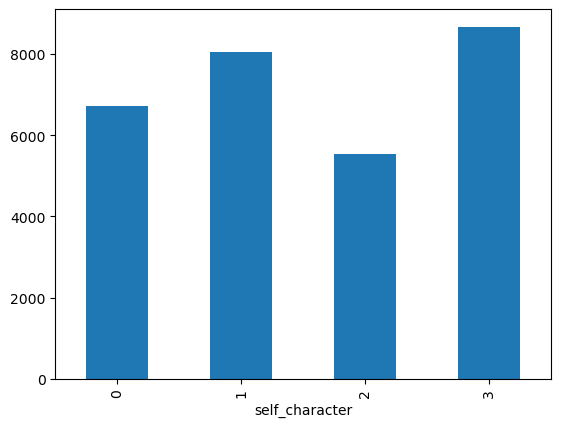

In [19]:
grouped_df = df_encoded.groupby('self_character').size()

grouped_df.plot(kind='bar')

plt.xlabel('self_character')
plt.ylabel('Count')
plt.title('Grouped Data by self_character')

plt.show()

In [20]:
# Find rows with NaN values
nan_rows = df_encoded[df_encoded.isnull().any(axis=1)]

# Print the rows with NaN values
nan_rows

,user_id,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally4_pre_spike_elims,ally4_post_spike_elims,ally4_pre_spike_deaths,...,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal,round_info_round_length


### Downsampling
-

In [21]:
correlation_matrix = df_encoded.corr()

# features correlated with other features
correlated_features = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:  # Adjust the correlation threshold as needed
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]
            correlated_features.append((feature_i, feature_j, correlation_value))

for feature_pair in correlated_features:
    feature_i, feature_j, correlation_value = feature_pair
    print(f"{feature_i} - {feature_j}: {correlation_value}")

round_info_round_start - round_info_round_end: 0.9953914691364327
ally4_pre_spike_headshots - ally4_pre_spike_elims: 0.8272216280281101
ally4_post_spike_headshots - ally4_post_spike_elims: 0.8740083524598403
self_pre_spike_headshots - self_pre_spike_elims: 0.8613332197439635
self_post_spike_headshots - self_post_spike_elims: 0.871206585930233
ally1_pre_spike_headshots - ally1_pre_spike_elims: 0.8292216758439522
ally1_post_spike_headshots - ally1_post_spike_elims: 0.895034948170309
ally2_pre_spike_headshots - ally2_pre_spike_elims: 0.827549792095154
ally2_post_spike_headshots - ally2_post_spike_elims: 0.878650896310773
ally3_pre_spike_headshots - ally3_pre_spike_elims: 0.833304788783171
ally3_post_spike_headshots - ally3_post_spike_elims: 0.9140707371303516
opponent0_pre_spike_headshots - opponent0_pre_spike_elims: 0.8331985146426686
opponent0_post_spike_headshots - opponent0_post_spike_elims: 0.8708647714208195
opponent1_pre_spike_headshots - opponent1_pre_spike_elims: 0.83356329856204

In [22]:
import numpy as np
cor = np.array(correlation_matrix)
plt.imshow(cor[:250,:250])

NameError: name 'plt' is not defined

## Decision Tree Classifier

### All data

In [24]:
df_dtree = df_encoded.copy()
df_dtree

,user_id,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally4_pre_spike_elims,ally4_post_spike_elims,ally4_pre_spike_deaths,...,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal,round_info_round_length
0,1006,2,0,0,124802,1,4723,0,0,0,...,0,0,0,0,0,0,0,0,1,120079
1,1006,2,0,0,204402,1,154802,0,0,0,...,0,0,0,0,0,0,0,0,1,49600
2,1006,2,1,278800,304570,1,234402,0,0,0,...,0,0,0,0,0,0,0,0,1,70168
3,1006,2,0,0,369242,1,334570,0,0,0,...,0,0,1,0,0,0,0,0,0,34672
4,1006,2,0,0,448998,1,399242,0,0,0,...,0,0,0,0,0,0,0,0,1,49756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28954,3795,2,0,0,1569092,1,1530671,0,0,0,...,0,0,0,0,0,0,0,0,1,38421
28955,3795,2,0,0,1632898,1,1599092,0,0,0,...,0,0,1,0,0,0,0,0,0,33806
28956,3795,2,1,1695907,1732124,0,1662898,0,0,0,...,0,0,1,0,0,0,0,0,0,69226
28957,3795,2,1,1811328,1834542,1,1762124,0,0,0,...,0,0,0,0,0,1,0,0,0,72418


In [25]:
# train test split
X = df_dtree.drop('self_character', axis=1)
y = df_dtree['self_character']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# # Scale the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [26]:
def d_tree(X_train,y_train,X_test,y_test):
    dtc = DecisionTreeClassifier(random_state=1)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)
    y_pred_train = dtc.predict(X_train)
    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_test, y_pred))

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return dtc

In [27]:
def f_importance(dtc):
    feature_importances = pd.DataFrame(dtc.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
    return feature_importances
    

In [28]:
dtc = d_tree(X_train,y_train,X_test,y_test)

NameError: name 'DecisionTreeClassifier' is not defined

In [ ]:
feature_importances = f_importance(dtc)

In [ ]:
feature_importances[:50]

## trying again w no user id

In [29]:
df_no_userid = df_encoded.copy()
df_no_userid = df_no_userid.drop('user_id', axis=1)
df_no_userid

,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally4_pre_spike_elims,ally4_post_spike_elims,ally4_pre_spike_deaths,ally4_post_spike_deaths,...,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal,round_info_round_length
0,2,0,0,124802,1,4723,0,0,0,0,...,0,0,0,0,0,0,0,0,1,120079
1,2,0,0,204402,1,154802,0,0,0,0,...,0,0,0,0,0,0,0,0,1,49600
2,2,1,278800,304570,1,234402,0,0,0,0,...,0,0,0,0,0,0,0,0,1,70168
3,2,0,0,369242,1,334570,0,0,0,0,...,0,0,1,0,0,0,0,0,0,34672
4,2,0,0,448998,1,399242,0,0,0,0,...,0,0,0,0,0,0,0,0,1,49756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28954,2,0,0,1569092,1,1530671,0,0,0,0,...,0,0,0,0,0,0,0,0,1,38421
28955,2,0,0,1632898,1,1599092,0,0,0,0,...,0,0,1,0,0,0,0,0,0,33806
28956,2,1,1695907,1732124,0,1662898,0,0,0,0,...,0,0,1,0,0,0,0,0,0,69226
28957,2,1,1811328,1834542,1,1762124,0,0,0,0,...,0,0,0,0,0,1,0,0,0,72418


In [ ]:
# train test split
X_nouser = df_no_userid.drop('self_character', axis=1)
y_nouser = df_no_userid['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_nouser, y_nouser, test_size=0.2, random_state=1)

In [ ]:
dtc_nouser = d_tree(X_train,y_train,X_test,y_test)

In [ ]:
feature_importances = f_importance(dtc_nouser)
feature_importances[:50]

In [30]:
# train test split
X_nouser = df_no_userid.drop('self_character', axis=1)
y_nouser = df_no_userid['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_nouser, y_nouser, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

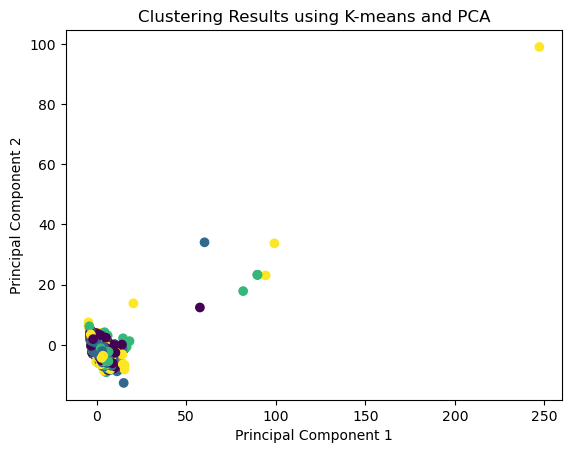

In [32]:
# Create an instance of K-means clustering algorithm
kmeans = KMeans(n_clusters=10)  # K is the number of clusters you want to create

# Fit the algorithm to the scaled training data
kmeans.fit(X_train_scaled)

# Predict cluster labels for the scaled testing data
test_cluster_labels = kmeans.predict(X_test_scaled)

# Create an instance of PCA and specify the number of components you want to keep
pca = PCA(n_components=2)

# Apply PCA to the scaled testing data
X_test_pca = pca.fit_transform(X_test_scaled)

# Create a scatter plot of the two principal components, color-coded by y_test
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis')  # Adjust the colormap as desired

# Add labels and title to the plot
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering Results using K-means and PCA')

# Display the plot
plt.show()

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## trying again w no user id, team characters 

In [37]:
df_no_chars = df_no_userid.copy()
columns_to_drop = [col for col in df_no_chars.columns if col.startswith('ally3_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('ally1_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('ally2_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('ally4_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent7_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent6_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent5_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent8_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = [col for col in df_no_chars.columns if col.startswith('opponent9_character')]
df_no_chars.drop(columns_to_drop, axis=1, inplace=True)

In [38]:
df_no_chars

,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally4_pre_spike_elims,ally4_post_spike_elims,ally4_pre_spike_deaths,ally4_post_spike_deaths,...,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal,round_info_round_length
0,2,0,0,124802,1,4723,0,0,0,0,...,0,0,0,0,0,0,0,0,1,120079
1,2,0,0,204402,1,154802,0,0,0,0,...,0,0,0,0,0,0,0,0,1,49600
2,2,1,278800,304570,1,234402,0,0,0,0,...,0,0,0,0,0,0,0,0,1,70168
3,2,0,0,369242,1,334570,0,0,0,0,...,0,0,1,0,0,0,0,0,0,34672
4,2,0,0,448998,1,399242,0,0,0,0,...,0,0,0,0,0,0,0,0,1,49756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28954,2,0,0,1569092,1,1530671,0,0,0,0,...,0,0,0,0,0,0,0,0,1,38421
28955,2,0,0,1632898,1,1599092,0,0,0,0,...,0,0,1,0,0,0,0,0,0,33806
28956,2,1,1695907,1732124,0,1662898,0,0,0,0,...,0,0,1,0,0,0,0,0,0,69226
28957,2,1,1811328,1834542,1,1762124,0,0,0,0,...,0,0,0,0,0,1,0,0,0,72418


In [39]:
# train test split
X_nocharnouser = df_no_chars.drop('self_character', axis=1)
y_nocharnouser= df_no_chars['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_nocharnouser, y_nocharnouser, test_size=0.2, random_state=1)

In [40]:
dtc_nousernochar = d_tree(X_train,y_train,X_test,y_test)

Train Accuracy: 1.0
[[5314    0    0    0]
 [   0 6454    0    0]
 [   0    0 4448    0]
 [   0    0    0 6951]]
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      1394
           1       0.73      0.76      0.75      1590
           2       0.55      0.54      0.54      1085
           3       0.75      0.75      0.75      1723

    accuracy                           0.69      5792
   macro avg       0.68      0.68      0.68      5792
weighted avg       0.69      0.69      0.69      5792

Test Accuracy: 0.694578729281768
[[ 944  143  170  137]
 [ 118 1204  142  126]
 [ 163  165  581  176]
 [ 134  130  165 1294]]
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      1394
           1       0.73      0.76      0.75      1590
           2       0.55      0.54      0.54      1085
           3       0.75      0.75      0.75      1723

    accuracy                           0.69      5792


In [41]:
feature_importances = f_importance(dtc_nousernochar)
feature_importances[:50]

,importance
ally3_pre_spike_avg_health,0.050168
ally1_pre_spike_avg_health,0.047199
ally2_pre_spike_avg_health,0.044029
ally4_pre_spike_avg_health,0.039603
self_pre_spike_avg_ammo_reserve,0.030153
ally4_pre_spike_total_health_loss,0.028565
ally3_pre_spike_total_health_loss,0.026773
ally4_pre_spike_max_health_loss,0.023356
self_pre_spike_avg_ammo_mag,0.023047
ally2_pre_spike_total_health_loss,0.021275


## trying again w no map

In [42]:
df_no_map = df_no_chars.copy()
columns_to_drop = [col for col in df_no_chars.columns if col.startswith('map_')]
df_no_map.drop(columns_to_drop, axis=1, inplace=True)
df_no_map

,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally4_pre_spike_elims,ally4_post_spike_elims,ally4_pre_spike_deaths,ally4_post_spike_deaths,...,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal,round_info_round_length
0,2,0,0,124802,1,4723,0,0,0,0,...,0,0,0,0,0,0,0,0,1,120079
1,2,0,0,204402,1,154802,0,0,0,0,...,0,0,0,0,0,0,0,0,1,49600
2,2,1,278800,304570,1,234402,0,0,0,0,...,0,0,0,0,0,0,0,0,1,70168
3,2,0,0,369242,1,334570,0,0,0,0,...,0,0,1,0,0,0,0,0,0,34672
4,2,0,0,448998,1,399242,0,0,0,0,...,0,0,0,0,0,0,0,0,1,49756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28954,2,0,0,1569092,1,1530671,0,0,0,0,...,0,0,0,0,0,0,0,0,1,38421
28955,2,0,0,1632898,1,1599092,0,0,0,0,...,0,0,1,0,0,0,0,0,0,33806
28956,2,1,1695907,1732124,0,1662898,0,0,0,0,...,0,0,1,0,0,0,0,0,0,69226
28957,2,1,1811328,1834542,1,1762124,0,0,0,0,...,0,0,0,0,0,1,0,0,0,72418


In [43]:
# train test split
X_nocharnousernomap = df_no_map.drop('self_character', axis=1)
y_nocharnousernomap = df_no_map['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_nocharnousernomap, y_nocharnousernomap, test_size=0.2, random_state=1)

In [44]:
dtc_nousernocharnomap = d_tree(X_train,y_train,X_test,y_test)

Train Accuracy: 1.0
[[5314    0    0    0]
 [   0 6454    0    0]
 [   0    0 4448    0]
 [   0    0    0 6951]]
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      1394
           1       0.71      0.73      0.72      1590
           2       0.49      0.48      0.49      1085
           3       0.71      0.72      0.71      1723

    accuracy                           0.66      5792
   macro avg       0.65      0.64      0.64      5792
weighted avg       0.66      0.66      0.66      5792

Test Accuracy: 0.6603936464088398
[[ 903  155  181  155]
 [ 115 1157  171  147]
 [ 183  167  525  210]
 [ 148  151  184 1240]]
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      1394
           1       0.71      0.73      0.72      1590
           2       0.49      0.48      0.49      1085
           3       0.71      0.72      0.71      1723

    accuracy                           0.66      5792

In [45]:
feature_importances = f_importance(dtc_nousernocharnomap)
feature_importances[:50]

,importance
ally1_pre_spike_avg_health,0.043511
ally3_pre_spike_avg_health,0.039242
ally4_pre_spike_avg_health,0.039085
ally2_pre_spike_avg_health,0.037175
self_pre_spike_avg_ammo_reserve,0.034980
self_pre_spike_map_covered,0.031043
ally4_pre_spike_total_health_loss,0.030024
self_pre_spike_avg_ammo_mag,0.024974
ally2_pre_spike_total_health_loss,0.024219
self_pre_spike_movement_metric,0.023855


In [46]:
# train test split
X_nocharnousernomap = df_no_map.drop('self_character', axis=1)
y_nocharnousernomap = df_no_map['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_nocharnousernomap, y_nocharnousernomap, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

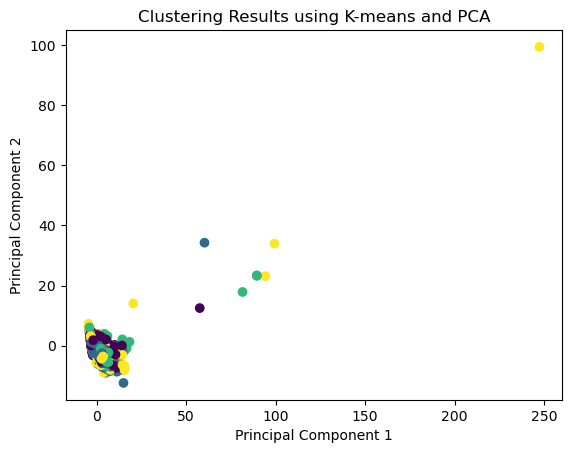

In [61]:
# Create an instance of K-means clustering algorithm
kmeans = KMeans(n_clusters=4)  # K is the number of clusters you want to create

# Fit the algorithm to the scaled training data
kmeans.fit(X_train_scaled)

# Predict cluster labels for the scaled testing data
test_cluster_labels = kmeans.predict(X_test_scaled)

# Create an instance of PCA and specify the number of components you want to keep
pca = PCA(n_components=2)

# Apply PCA to the scaled testing data
X_test_pca = pca.fit_transform(X_test_scaled)

# Create a scatter plot of the two principal components, color-coded by y_test
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis')  # Adjust the colormap as desired

# Add labels and title to the plot
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering Results using K-means and PCA')

# Display the plot
plt.show()

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


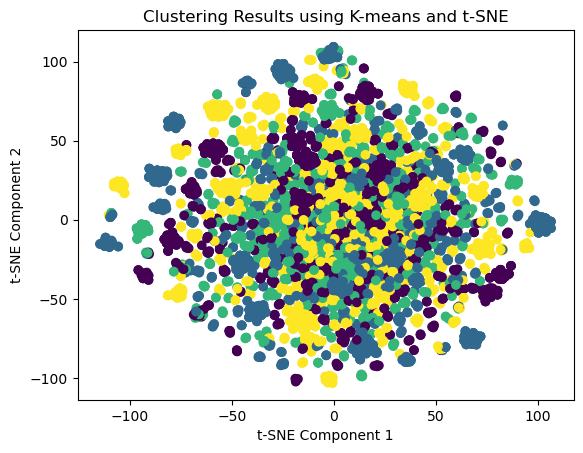

In [38]:
# Create an instance of K-means clustering algorithm
kmeans = KMeans(n_clusters=4)  # K is the number of clusters you want to create

# Fit the algorithm to the scaled training data
kmeans.fit(X_train_scaled)

# Predict cluster labels for the scaled testing data
test_cluster_labels = kmeans.predict(X_test_scaled)

# Create an instance of t-SNE and specify the desired number of dimensions (components)
tsne = TSNE(n_components=2, random_state=1)

# Apply t-SNE to the scaled testing data
X_test_tsne = tsne.fit_transform(X_test_scaled)

# Create a scatter plot of the t-SNE embedding, color-coded by y_test
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test, cmap='viridis')  # Adjust the colormap as desired

# Add labels and title to the plot
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Clustering Results using K-means and t-SNE')

# Display the plot
plt.show()

In [35]:
X_embedded = TSNE(n_components=2,perplexity=100).fit_transform(X_train_scaled)

/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/sophiacofone/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [36]:
def plot_2d(pts, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.suptitle(title, size=16)
    ax.scatter(pts[:, 0], pts[:, 1])
    plt.show()

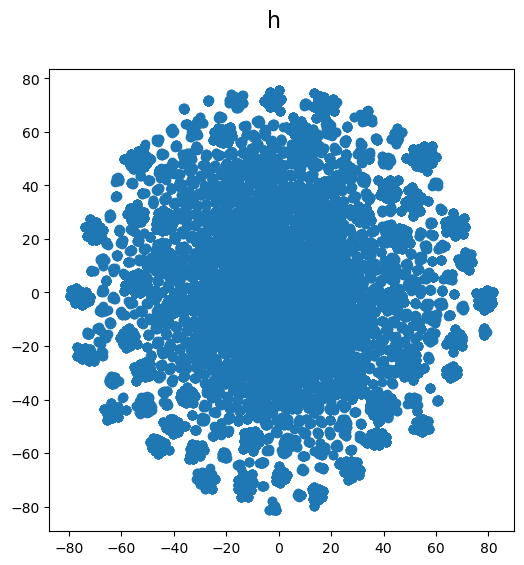

In [37]:
plot_2d(X_embedded,'h')

### looking at spike only matches

In [37]:
df_spike = df_no_map.copy()
df_spike = df_spike[df_spike['spike_planted'] == 1]
df_spike

,self_character,spike_planted,spike_time,round_info_round_end,round_info_round_won,round_info_round_start,ally4_pre_spike_elims,ally4_post_spike_elims,ally4_pre_spike_deaths,ally4_post_spike_deaths,...,self_pre_spike_longest_gun_primary_judge,self_pre_spike_longest_gun_primary_marshal,self_pre_spike_longest_gun_primary_none,self_pre_spike_longest_gun_primary_odin,self_pre_spike_longest_gun_primary_operator,self_pre_spike_longest_gun_primary_phantom,self_pre_spike_longest_gun_primary_spectre,self_pre_spike_longest_gun_primary_stinger,self_pre_spike_longest_gun_primary_vandal,round_info_round_length
2,2,1,278800,304570,1,234402,0,0,0,0,...,0,0,0,0,0,0,0,0,1,70168
5,2,1,530000,561796,1,493998,0,0,0,0,...,0,0,1,0,0,0,0,0,0,67798
8,2,1,801600,844400,1,746800,0,0,0,0,...,0,0,1,0,0,0,0,0,0,97600
10,3,1,227400,253037,1,204188,1,0,0,1,...,0,0,1,0,0,0,0,0,0,48849
15,3,1,631600,672339,1,606009,0,0,0,1,...,0,0,1,0,0,0,0,0,0,66330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28949,2,1,1108601,1128211,1,1080595,0,0,0,0,...,0,0,1,0,0,0,0,0,0,47616
28950,2,1,1175813,1210781,0,1158211,0,0,0,0,...,0,0,0,0,0,0,1,0,0,52570
28952,2,1,1370248,1401265,1,1316840,0,0,0,0,...,1,0,0,0,0,0,0,0,0,84425
28956,2,1,1695907,1732124,0,1662898,0,0,0,0,...,0,0,1,0,0,0,0,0,0,69226


In [38]:
# train test split
X_spike = df_spike.drop('self_character', axis=1)
y_spike = df_spike['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_spike, y_spike, test_size=0.2, random_state=1)

In [39]:
dtc_spike = d_tree(X_train,y_train,X_test,y_test)

Train Accuracy: 1.0
[[2602    0    0    0]
 [   0 3284    0    0]
 [   0    0 2169    0]
 [   0    0    0 3507]]
              precision    recall  f1-score   support

           0       0.65      0.62      0.63       682
           1       0.70      0.74      0.72       766
           2       0.52      0.46      0.49       578
           3       0.67      0.71      0.69       865

    accuracy                           0.65      2891
   macro avg       0.64      0.63      0.63      2891
weighted avg       0.64      0.65      0.65      2891

Test Accuracy: 0.647872708405396
[[423  71  86 102]
 [ 53 567  64  82]
 [ 96  97 267 118]
 [ 79  75  95 616]]
              precision    recall  f1-score   support

           0       0.65      0.62      0.63       682
           1       0.70      0.74      0.72       766
           2       0.52      0.46      0.49       578
           3       0.67      0.71      0.69       865

    accuracy                           0.65      2891
   macro avg    

In [77]:
feature_importances = f_importance(dtc_spike)
feature_importances[:50]

,importance
ally1_pre_spike_avg_health,0.054958
ally2_pre_spike_avg_health,0.041524
self_pre_spike_avg_ammo_reserve,0.036006
self_pre_spike_map_covered,0.034765
ally4_pre_spike_avg_health,0.033256
ally3_pre_spike_avg_health,0.029924
ally4_pre_spike_total_health_loss,0.021728
self_pre_spike_avg_loadout_value,0.020465
ally3_pre_spike_total_health_loss,0.017557
self_pre_spike_avg_credits,0.017312


In [78]:
dtc_spike.get_depth()

43

In [87]:
def d_tree_tuned(X_train,y_train,X_test,y_test,depth):
    dtc = DecisionTreeClassifier(max_depth=depth,random_state=1)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)
    y_pred_train = dtc.predict(X_train)
    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_test, y_pred))

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return dtc

In [88]:
dtc_spike_tuned = d_tree_tuned(X_train,y_train,X_test,y_test,20)

Train Accuracy: 0.925964366026639
[[2393   54   67   88]
 [  53 3076   63   92]
 [  34   73 1951  111]
 [  51   92   78 3286]]
              precision    recall  f1-score   support

           0       0.66      0.60      0.63       682
           1       0.66      0.73      0.69       766
           2       0.53      0.47      0.50       578
           3       0.67      0.71      0.69       865

    accuracy                           0.64      2891
   macro avg       0.63      0.63      0.63      2891
weighted avg       0.64      0.64      0.64      2891

Test Accuracy: 0.6413005880318229
[[411  85  79 107]
 [ 54 557  68  87]
 [ 88 113 271 106]
 [ 70  85  95 615]]
              precision    recall  f1-score   support

           0       0.66      0.60      0.63       682
           1       0.66      0.73      0.69       766
           2       0.53      0.47      0.50       578
           3       0.67      0.71      0.69       865

    accuracy                           0.64      2891
 

In [100]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def lda(X_train,y_train,X_test,y_test):
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_pred_train = lda.predict(X_train)
    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_test, y_pred))

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return lda
    

In [101]:
lda = lda(X_train,y_train,X_test,y_test)

Train Accuracy: 0.5670299256184052
[[1380  470  246  506]
 [ 371 2031  277  605]
 [ 272  473  943  481]
 [ 357  640  308 2202]]
              precision    recall  f1-score   support

           0       0.58      0.52      0.55       682
           1       0.51      0.57      0.54       766
           2       0.54      0.42      0.47       578
           3       0.57      0.65      0.61       865

    accuracy                           0.55      2891
   macro avg       0.55      0.54      0.54      2891
weighted avg       0.55      0.55      0.55      2891

Test Accuracy: 0.5503286060186786
[[358 121  57 146]
 [102 433  74 157]
 [ 86 137 240 115]
 [ 76 155  74 560]]
              precision    recall  f1-score   support

           0       0.58      0.52      0.55       682
           1       0.51      0.57      0.54       766
           2       0.54      0.42      0.47       578
           3       0.57      0.65      0.61       865

    accuracy                           0.55      2891


In [40]:
# train test split
X_spike = df_spike.drop('self_character', axis=1)
y_spike = df_spike['self_character']

X_train, X_test, y_train, y_test = train_test_split(X_spike, y_spike, test_size=0.2, random_state=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
from sklearn.neighbors import KNeighborsClassifier

def knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_pred_train = knn.predict(X_train)

    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return knn

In [43]:
knn_model = knn(X_train_scaled, y_train, X_test_scaled, y_test, n_neighbors=10)

Train Accuracy: 0.6565473101539526
[[1630  338  259  375]
 [ 241 2426  221  396]
 [ 278  462 1024  405]
 [ 263  443  290 2511]]
              precision    recall  f1-score   support

           0       0.68      0.63      0.65      2602
           1       0.66      0.74      0.70      3284
           2       0.57      0.47      0.52      2169
           3       0.68      0.72      0.70      3507

    accuracy                           0.66     11562
   macro avg       0.65      0.64      0.64     11562
weighted avg       0.65      0.66      0.65     11562

Test Accuracy: 0.5845728121757178
[[371 113  88 110]
 [ 70 528  66 102]
 [ 82 161 211 124]
 [ 75 119  91 580]]
              precision    recall  f1-score   support

           0       0.62      0.54      0.58       682
           1       0.57      0.69      0.63       766
           2       0.46      0.37      0.41       578
           3       0.63      0.67      0.65       865

    accuracy                           0.58      2891


In [44]:
from sklearn.svm import SVC

def svm(X_train, y_train, X_test, y_test):
    svm_model = SVC(decision_function_shape='ovr')
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    y_pred_train = svm_model.predict(X_train)

    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return svm_model

In [112]:
svm_model = svm(X_train_scaled, y_train, X_test_scaled, y_test)

Train Accuracy: 0.8695727382805742
[[2180  129  129  164]
 [ 106 2911   99  168]
 [  88  143 1761  177]
 [  84  110  111 3202]]
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      2602
           1       0.88      0.89      0.89      3284
           2       0.84      0.81      0.83      2169
           3       0.86      0.91      0.89      3507

    accuracy                           0.87     11562
   macro avg       0.87      0.86      0.86     11562
weighted avg       0.87      0.87      0.87     11562

Test Accuracy: 0.6952611553095814
[[422  57  93 110]
 [ 46 569  61  90]
 [ 56  81 341 100]
 [ 55  64  68 678]]
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       682
           1       0.74      0.74      0.74       766
           2       0.61      0.59      0.60       578
           3       0.69      0.78      0.74       865

    accuracy                           0.70      2891


In [117]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

def svm_tune(X_train, y_train, X_test, y_test):
    parameters = {'C': [0.1, 1, 10, 100]}
    grid = GridSearchCV(SVC(), parameters, refit=True, verbose=2)
    grid.fit(X_train, y_train)
    
    # After fitting, the best model can be selected with grid.best_estimator_
    svm_model = grid.best_estimator_
    
    y_pred = svm_model.predict(X_test)
    y_pred_train = svm_model.predict(X_train)

    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return svm_model


In [118]:
svm_model_tune = svm_tune(X_train_scaled, y_train, X_test_scaled, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..............................................C=0.1; total time=  22.6s
[CV] END ..............................................C=0.1; total time=  22.7s
[CV] END ..............................................C=0.1; total time=  22.8s
[CV] END ..............................................C=0.1; total time=  23.3s
[CV] END ..............................................C=0.1; total time=  22.9s
[CV] END ................................................C=1; total time=  17.5s
[CV] END ................................................C=1; total time=  17.4s
[CV] END ................................................C=1; total time=  17.1s
[CV] END ................................................C=1; total time=  17.2s
[CV] END ................................................C=1; total time=  17.5s
[CV] END ...............................................C=10; total time=  17.4s
[CV] END ........................................

In [47]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

def svm_tune(X_train, y_train, X_test, y_test):
    parameters = {'gamma': [1, 0.1, 0.01, 0.001]}
    grid = GridSearchCV(SVC(), parameters, refit=True, verbose=2)
    grid.fit(X_train, y_train)
    
    # After fitting, the best model can be selected with grid.best_estimator_
    svm_model = grid.best_estimator_
    
    y_pred = svm_model.predict(X_test)
    y_pred_train = svm_model.predict(X_train)

    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return svm_model

In [48]:
svm_model_tune = svm_tune(X_train_scaled, y_train, X_test_scaled, y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ............................................gamma=1; total time=  24.0s
[CV] END ............................................gamma=1; total time=  25.3s
[CV] END ............................................gamma=1; total time=  26.8s
[CV] END ............................................gamma=1; total time=  25.7s
[CV] END ............................................gamma=1; total time=  24.7s
[CV] END ..........................................gamma=0.1; total time=  23.7s
[CV] END ..........................................gamma=0.1; total time=  29.5s
[CV] END ..........................................gamma=0.1; total time=  31.9s
[CV] END ..........................................gamma=0.1; total time=  30.0s
[CV] END ..........................................gamma=0.1; total time=  32.6s
[CV] END .........................................gamma=0.01; total time=  29.1s
[CV] END ........................................

In [49]:
def svm_tune(X_train, y_train, X_test, y_test):
    parameters = {'kernel': ['linear', 'rbf']}
    grid = GridSearchCV(SVC(), parameters, refit=True, verbose=2)
    grid.fit(X_train, y_train)
    
    # After fitting, the best model can be selected with grid.best_estimator_
    svm_model = grid.best_estimator_
    
    y_pred = svm_model.predict(X_test)
    y_pred_train = svm_model.predict(X_train)

    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return svm_model

In [ ]:
svm_model_tune = svm_tune(X_train_scaled, y_train, X_test_scaled, y_test)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def d_tree_tuning(X_train, y_train, X_test, y_test):
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'max_depth': [10, 20, 30],  # Example values for max_depth
        'min_samples_leaf': [1, 2, 3],  # Example values for min_samples_leaf
        'min_samples_split': [2, 5, 10]  # Example values for min_samples_split
    }

    # Create a decision tree classifier
    dtc = DecisionTreeClassifier(random_state=1)

    # Create a GridSearchCV object with the decision tree classifier and parameter grid
    grid_search = GridSearchCV(dtc, param_grid, cv=5)  # Adjust cv value as needed

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Retrieve the best hyperparameters and create a decision tree with those settings
    best_dtc = grid_search.best_estimator_

    # Predict on the training set using the best model
    y_pred_train = best_dtc.predict(X_train)

    # Predict on the test set using the best model
    y_pred = best_dtc.predict(X_test)

    # Print evaluation metrics for the training set
    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    # Print evaluation metrics for the test set
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return best_dtc

In [59]:
dtc_tune = d_tree_tuning(X_train,y_train,X_test,y_test)

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def random_forest(X_train, y_train, X_test, y_test):
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100, 200],  # Example values for n_estimators
        'max_depth': [10, 15, 20],  # Example values for max_depth
    }

    # Create a random forest classifier
    rfc = RandomForestClassifier(random_state=1)

    # Create a GridSearchCV object with the random forest classifier and parameter grid
    grid_search = GridSearchCV(rfc, param_grid, cv=5)  # Adjust cv value as needed

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Retrieve the best hyperparameters and create a random forest classifier with those settings
    best_rfc = grid_search.best_estimator_

    # Predict on the training set using the best model
    y_pred_train = best_rfc.predict(X_train)

    # Predict on the test set using the best model
    y_pred = best_rfc.predict(X_test)

    # Print evaluation metrics for the training set
    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    # Print evaluation metrics for the test set
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return best_rfc


In [ ]:
rf = random_forest(X_train,y_train,X_test,y_test)

In [ ]:
rf.get_params()

In [116]:
def tune_gbm(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],  # Vary the number of estimators
        'learning_rate': [0.1, 0.05, 0.01],  # Vary the learning rate
        'max_depth': [3, 4, 5]  # Vary the maximum depth of trees
    }

    gbc = GradientBoostingClassifier(random_state=1)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(gbc, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Print the best parameters found during tuning
    print("Best Parameters:", grid_search.best_params_)

    return grid_search.best_estimator_

def gradient_boosting(X_train, y_train, X_test, y_test):
    # Hyperparameter tuning and CV
    gbc_tuned = tune_gbm(X_train, y_train)
    gbc_tuned.fit(X_train, y_train)

    y_pred = gbc_tuned.predict(X_test)
    y_pred_train = gbc_tuned.predict(X_train)

    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return gbc_tuned


In [117]:
gbc = gradient_boosting(X_train,y_train,X_test,y_test)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Train Accuracy: 0.9375872905027933
[[5079  103   88   80]
 [ 125 5952  101  111]
 [ 127  133 3837  237]
 [ 111   81  133 6614]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5350
           1       0.95      0.95      0.95      6289
           2       0.92      0.89      0.90      4334
           3       0.94      0.95      0.95      6939

    accuracy                           0.94     22912
   macro avg       0.94      0.93      0.93     22912
weighted avg       0.94      0.94      0.94     22912

Test Accuracy: 0.7700768156424581
[[1036  107  106   79]
 [ 106 1307  108  111]
 [  98  113  666  194]
 [  87   87  121 1402]]
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1328
           1       0.81      0.80      0.81      1632
           2       0.67      0.62      0.64      1071
           3    

In [ ]:
def tune_gbm(X_train, y_train):
    param_grid = {
        'n_estimators': [300],  # Vary the number of estimators
        'learning_rate': [0.1],  # Vary the learning rate
        'max_depth': [5]  # Vary the maximum depth of trees
    }

    gbc = GradientBoostingClassifier(random_state=1)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(gbc, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Print the best parameters found during tuning
    print("Best Parameters:", grid_search.best_params_)

    return grid_search.best_estimator_

def gradient_boosting(X_train, y_train, X_test, y_test):
    # Hyperparameter tuning and CV
    gbc_tuned = tune_gbm(X_train, y_train)
    gbc_tuned.fit(X_train, y_train)

    y_pred = gbc_tuned.predict(X_test)
    y_pred_train = gbc_tuned.predict(X_train)

    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return gbc_tuned
